New version of cashout analysis. Includes code to check that the year is being logged correctly for all data points, and to fix these incorrect entries.


In [ ]:
#load relevant libraries
import pandas as pd
from pandas import DataFrame 
from pandas import Series
import json,csv
#import delorean
import matplotlib.pyplot as plt
#this allows your graphs to show up in the nb, super important
%matplotlib inline 
import datetime
from datetime import datetime
import matplotlib.dates as mdates
from collections import defaultdict 
import numpy as np
import math

#import this to make network graphs
import networkx as nx
#helps you make prettier graphs
import seaborn as sns 

In [ ]:
#make a dictionary for all the group names
groupDict = {
    0.0: 'white-group',
    1.0: 'red-group',
    2.0: 'green-group',
    3.0: 'pink-group',
    4.0: 'blue-group',
    5.0: 'yellow-group',
    6.0: 'orange-group',
    7.0: 'turquoise-group',
    8.0: 'fuschia-group'
}

In [ ]:
#open data file
#this data is from the first 2 games of the day
infilename = "events-feb-4-two-plays.json"
infile = open(infilename,'rb')
#read each line of json 
mydata = []
for line in infile:
    mydata.append(json.loads(line))

#make a dataframe from the data
myData1 = DataFrame(mydata)

#open data file
#this data is from the afternoon game
infilename = "events-feb-4-last.json"
infile = open(infilename,'rb')
#read each line of json 
mydata2 = []
for line in infile:
    mydata2.append(json.loads(line))

#make a dataframe from the data
myData2 = DataFrame(mydata2)

#make one big dataframe for all the data
myData = pd.concat([myData1,myData2])

Games in the data:
- myData1 has game 51092 (1st game) and game 2416 (2nd game)
- myData2 has game 1730 (3rd game)

In [ ]:
#some functions
#function to convert list of epoch times in milliseconds to a list of python datetimes
def convertTime(timeList):
    for i in range(len(timeList)):
        tempTime= datetime.fromtimestamp(timeList[i]/1000)
        timeList[i]=tempTime 
    return timeList;

#function to grab timestamp for when a year started
#this function does not handle the first year of the game; need to add to it!
def getYearStart(myYear, myData, myGame):
    df = myData[(myData.gameCode==myGame)&(myData.key=='GameYearIncrease')&(myData.newYearValue==myYear)]
    if len(df)==0:
        #check if this is the starting year
        df = myData[(myData.gameCode==myGame)&(myData.key=='NewGameStart')]
        if len(df)!=0:
            if myYear == df.iloc[0]['startingYear']:
                return df.iloc[0]['timestamp']
            else: 
                return -1
        else:
            return -1 #returns -1 if year is not in the game
    else:
        return df.iloc[0]['timestamp']
    

In [ ]:
#this function gets the year in the game for a given timestamp
def getYear(myTime,myData,myGame):
    df = myData[myData.gameCode==myGame]
    dfYear = df[df.key=='GameYearIncrease']
    maxYear = int(max(dfYear['newYearValue']))
    minYear = int(min(dfYear['newYearValue'])-1)
    myYear = -1
    for y in range(minYear,maxYear+1):
        #check if timestamp is in this year
        yStart = getYearStart(y,myData,myGame)
        if y<maxYear:
            yEnd = getYearStart(y+1,myData,myGame)
        else:
            yEnd = max(df['timestamp'])
        if (myTime>yStart) & (myTime<yEnd):
            myYear = y
            break
    return myYear
            
    

In [110]:
#a few of the events logged in the data were mislabeled with the wrong year
#this function takes a dataframe, and relabels all the years based on when GameYearIncrease events occurred
#it then returns a dataframe with these new values for the year variable
def fixYearLabels(myData,myGame):
    df = myData[myData.gameCode==myGame]

    #sort data by timestamp
    df = df.sort_values(['timestamp'])
    df = df.reset_index(drop=True)
    
    dfYear = df[df.key=='GameYearIncrease']
    yearIndices = dfYear.index.tolist()
    maxYear = max(dfYear['newYearValue'])
    minYear = min(dfYear['newYearValue'])-1
    
    #make a list of the indices for all the years
    #first col is the year, second col is the lower end of the index range, third col is the higher end of the index range
    yearChanges = []
    #first append the index range for the first year of the game
    minIndex = min(df.index.tolist())
    yearChanges.append([minYear,minIndex,yearIndices[0]])

    #then loop through and append for each year
    for i in range(1,len(yearIndices)):
        index = yearIndices[i]
        pastIndex = yearIndices[i-1]
        newYear = dfYear.loc[pastIndex]['newYearValue']
        yearChanges.append([newYear,pastIndex,index])

    #and add a row for the last year of the game
    maxIndex = max(df.index.tolist())
    yearChanges.append([maxYear,max(yearIndices),maxIndex])
    
    #now loop through year changes and reset all values
    for i in range(len(yearChanges)):
        j=yearChanges[i][1]
        k=yearChanges[i][2]
        y=yearChanges[i][0]
        df.loc[j:k,'year']=y
    
    return df


In [111]:
#this function totals up the cashouts for a group in a given game
#returns a dataframe with the columns 'cashTotal','timestamp','datetime',and 'year'
def runningCash(groupId, myData, myGame):
    
    df = myData[myData.gameCode==myGame]
    
    dfYear = df[df.key=='GameYearIncrease']
    startingYear = min(dfYear['newYearValue'])-1
    endingYear = max(dfYear['newYearValue'])
    yearList  = range(int(startingYear),int(endingYear)+1)
    
    dfCash = df[(df.key=='CashingOutResource')&(df.group==groupId)]

    #initialize lists, will combine into df later
    cash = list()
    time = list()
    year = list()
    
    #now go through all the year
    for y in yearList:
        curDF = dfCash[dfCash['year']==y]
    
        #first add a zero entry for the year start
        yearStartTime = getYearStart(y,myData,myGame)
        cashTotal = 0
        cash.append(cashTotal)
        time.append(yearStartTime)
        year.append(y)
    
        #then loop through all the cashout entries
        for i in range(len(curDF)):
            cashTotal = cashTotal + curDF.iloc[i]['cash']
            curTime = curDF.iloc[i]['timestamp']
            thisyear = y
            if y<max(yearList):
                thisYearStartTime = getYearStart(y,myData,myGame)
                nextYearStartTime = getYearStart(y+1,myData,myGame)
                if curTime>nextYearStartTime:
                    print 'help!'
                    thisyear = y+1
            cash.append(cashTotal)
            time.append(curTime)
            year.append(thisyear)
    
        #then add one more entry just before the next change
        #only do this if this isn't the last year
        if y<max(yearList):
            nextYearStartTime = getYearStart(y+1,myData,myGame)
            tempTime = nextYearStartTime - 100
            cash.append(cashTotal)
            time.append(tempTime)
            year.append(y)
        
    #now make these columns into a dataframe  
    #now make a data frame with these cols
    newDF = pd.DataFrame(
        {'cashTotal': cash,
         'timestamp': time,
         'datetime': convertTime(time),
         'year': year
        })  
    
    return newDF

In [112]:
#this code will make a plot of cashouts for all groups in a given game
#uses the functions runningCash and getYearStart

def plotCashouts(myData,myGame,groupDict):
    dfYear = myData[(myData.key=='GameYearIncrease') & (myData.gameCode==myGame)]
    cashoutDF = myData[(myData.key=='CashingOutResource') & (myData.gameCode==myGame)]
    groups = list(set(cashoutDF['group']))

    #initialize figure
    fig, ax = plt.subplots(figsize=(20, 10))

    #now loop through all the groups and plot cashouts
    for group in groups:
        groupCash = runningCash(group,myData,myGame)
        sortedGroupCash = groupCash.sort_values(['timestamp'])
        groupName = groupDict[group]
        myLabel = groupName 
        myColor = groupName.replace("-group", "")    
        if myColor=='white':
            myColor = 'black'
        plt.plot(sortedGroupCash['datetime'],sortedGroupCash['cashTotal'],label=myLabel,color=myColor,linewidth=3)


    #use the next few lines to set the axis range
    #xmin = datetime.strptime('2017-02-02 17:45:00', '%Y-%m-%d %H:%M:%S')
    #xmax = datetime.strptime('2017-02-02 18:20:00', '%Y-%m-%d %H:%M:%S')
    #ax.set_xlim([xmin,xmax])

    #add dashed lines for each year change
    ymin = (ax.get_ylim())[0]
    ymax = (ax.get_ylim())[1]
    for i in range(len(dfYear)):
        time = datetime.fromtimestamp((dfYear.iloc[i]['timestamp'])/1000)
        #if time<xmin:
        #    continue
        curYear = dfYear.iloc[i]['newYearValue']
        plt.plot((time, time), (ymin, ymax), 'k--')
        plt.text(time,ymax-50,('  year: '+str(curYear)),size=14)

    #format the axis so times will be legible
    #plt.gcf().autofmt_xdate()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    #add legend, labels, etc
    #ax = plt.subplot(111)
    #globally sets font size for legend
    plt.rc('legend',**{'fontsize':14})
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    #the next line moves the legend to the right of the plot (and at 80% of the y-axis height)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))

    plt.xlabel('time',size=14)
    plt.ylabel('cash on hand',size=14)
    myTitle = 'Game '+myGame+': Amount Cashed Out Over Time'
    plt.title(myTitle,size=18)

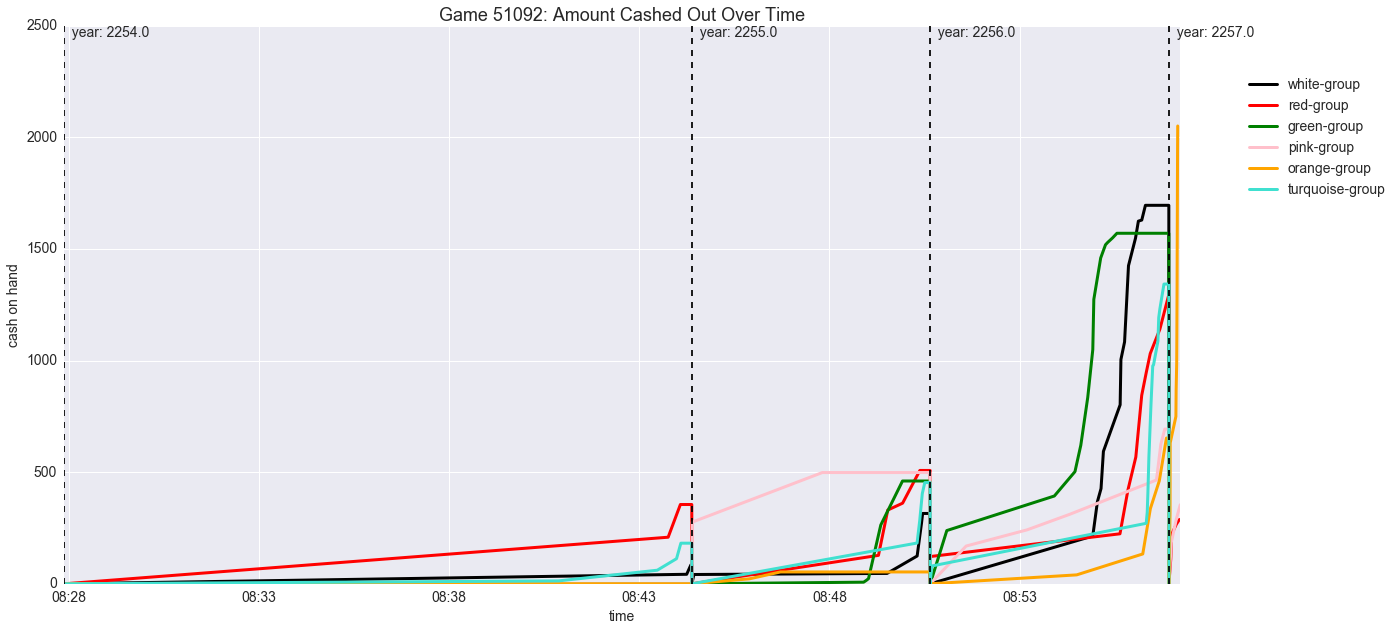

In [113]:
#to make cashout plots, first need to fix all the year labels
#then feed that cleaned up dataframe into the plotCashouts function
data51092 = fixYearLabels(myData,'51092')
plotCashouts(data51092,'51092',groupDict)





In the plot above, the years vary in length because the game was occasionally paused

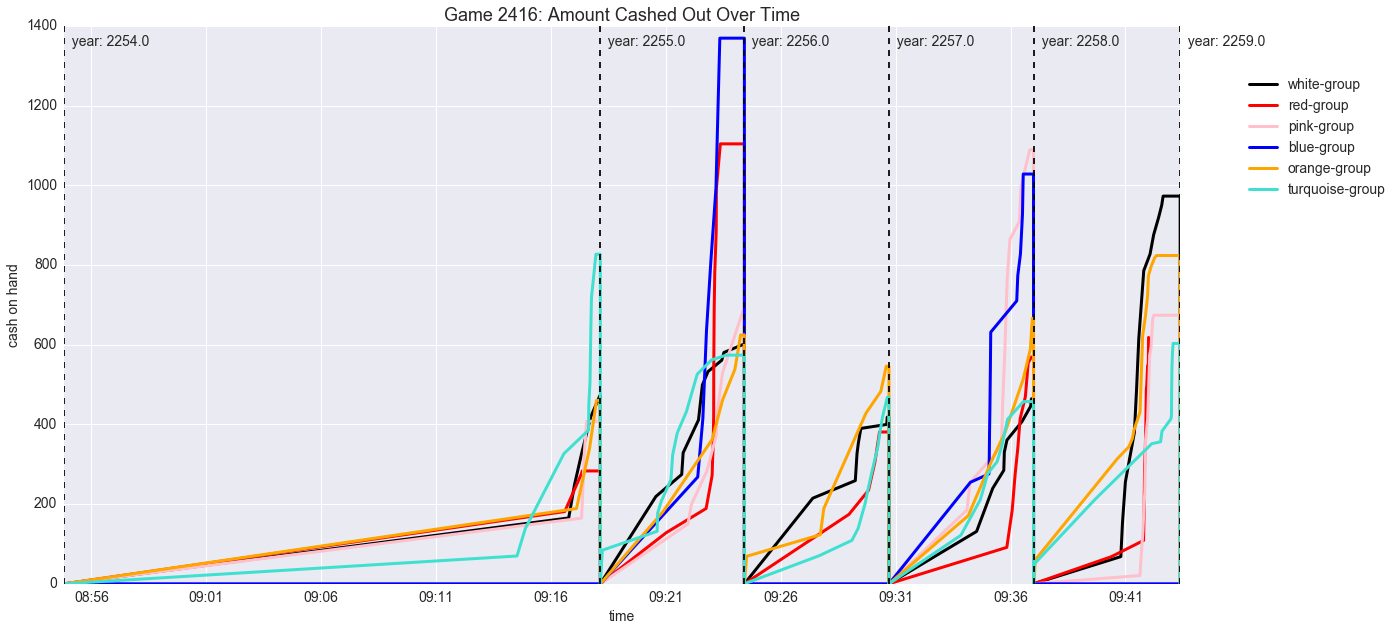

In [114]:
data2416 = fixYearLabels(myData,'2416')
plotCashouts(data2416,'2416',groupDict)



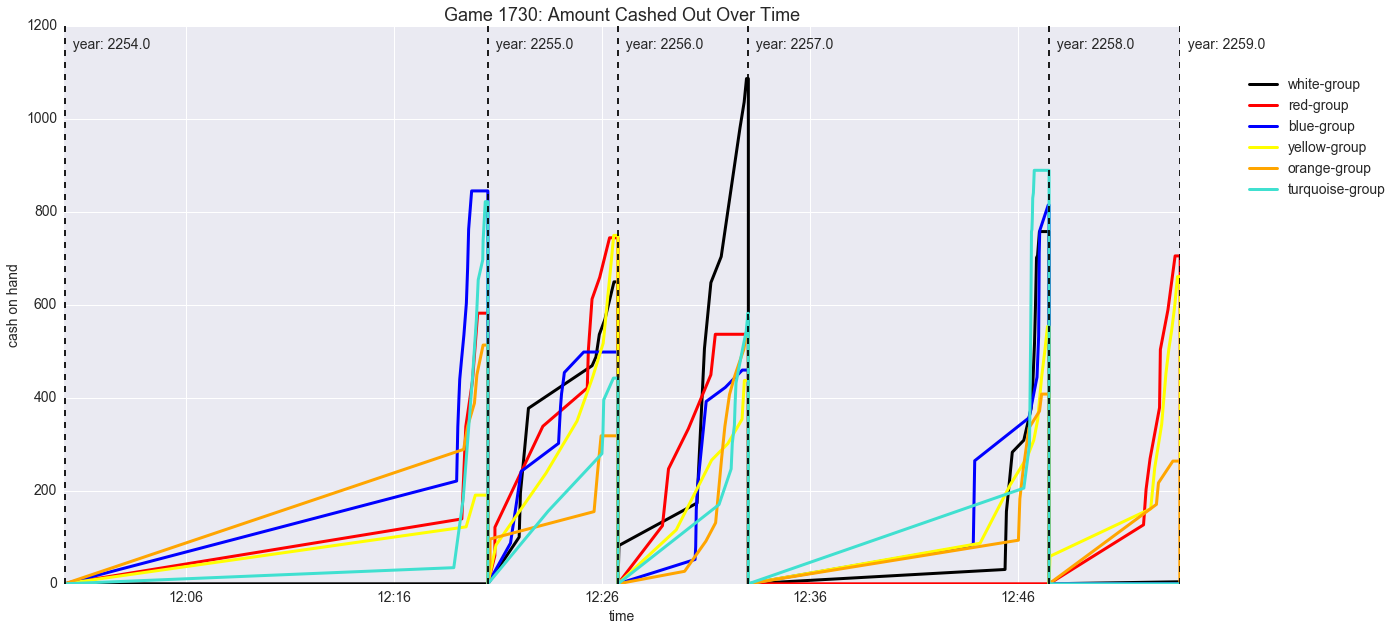

In [115]:
data1730 = fixYearLabels(myData2,'1730')
plotCashouts(data1730,'1730',groupDict)
